## Simulating the Evolution of Teamwork

This simulation is based on the eponymous Primer video. The setup is as follows: Each day, blobs go out to explore their surroundings. They forage for fruit to reproduce. If they find a tree all to themselves they collect both the fruits. There are two kinds of blobs- "team" blobs and "solo" blobs. If two team blobs find the same tree, they work together and shake the tree, dividing the obtained fruit in half but losing some utility due to the energy required to shake the tree. If two solo blobs find the same tree, they obtain some fruit, but lose some energy due to fighting over the fruit. Lastly if a team and solo blob find the same tree, the fruit is distributed unevenly.

Each tree can be found by at most two blobs, any other blobs without a tree die.

At the end of the day, the blobs return and reproduce. The rules for reproduction are as follows: Say a blob has (I+F) fruit where I is an integer and F is a fraction. Then the blob produces I new blobs for sure, and 1 more new blob with probability F. Every blob dies after reproducing. We assume no random mutations during reproduction ie, team blobs always produce team blobs and solo blobs always produce solo blobs.

In [84]:
import math
import random
import numpy as np
from matplotlib import pyplot as plt

In [85]:
curr_blob_id = 0
curr_game_id = 0
num_strategies = 2

A blob's strategy is an array representing probability distributions over team (0) and solo (1). `strategy[i]` denotes the probability of playing the ith strategy.

In [86]:
class Blob:
    def __init__(self, strategy, type, speed = 1, size = 1, health = 1):

        global curr_blob_id

        self.id = curr_blob_id
        curr_blob_id += 1
        self.strategy = strategy
        self.speed = speed
        self.size = size
        self.health = health
        self.util = None
        self.type = type    # including this temporarily specifically for the primer sim. 0/1

`blobs` is a list of `blob` objects.

In [87]:
class Game:
    def __init__(self, sr, tt, ts, st, ss, blobs, num_trees, num_team, num_solo, num_episodes):

        global curr_game_id

        self.id = curr_game_id
        curr_game_id += 1
        self.solo_reward = sr
        self.reward_matrix = np.array([[tt, ts], [st, ss]])
        self.blobs = blobs
        self.num_trees = num_trees
        self.num_team = num_team    # again specifically for the primer sim
        self.num_solo = num_solo
        self.num_team_init = num_team
        self.num_solo_init = num_solo
        self.team_util = 0
        self.solo_util = 0
        self.num_episodes = num_episodes
        self.team_avg = []
        self.solo_avg = []
        self.team_percentage = []
        self.solo_percentage = []
        

In [88]:
def episode(game, blob1, blob2):

    global num_strategies

    action1 = np.random.choice(range(num_strategies), p = blob1.strategy)
    action2 = np.random.choice(range(num_strategies), p = blob2.strategy)

    util1 = game.reward_matrix[action1][action2]
    util2 = game.reward_matrix[action2][action1]

    return [util1, util2]

In [89]:
def reproduce(blobs):
    new_blobs = []
    new_team = 0
    new_solo = 0
    for blob in blobs:
        # print(blob.util)
        for i in range(math.floor(blob.util)):
            new_blobs.append(Blob(blob.strategy, blob.type))

        if blob.type == 0:
            new_team += math.floor(blob.util)
        else:
            new_solo += math.floor(blob.util)

        random_num = random.uniform(0, 1)
        
        if random_num <= (blob.util - math.floor(blob.util)):
            new_blobs.append(Blob(blob.strategy, blob.type))
            
            if blob.type == 0:
                new_team += 1
            else:
                new_solo += 1

    return new_blobs, new_team, new_solo

In [90]:
def simulate(game):
    for i in range(game.num_episodes):
        game.team_percentage.append(game.num_team/(game.num_team+game.num_solo)*100)
        game.solo_percentage.append(game.num_solo/(game.num_team+game.num_solo)*100)

        num_blobs = len(game.blobs)
        permut = game.blobs
        random.shuffle(permut)
        # print(game.blobs)
        # print(permut)

        if num_blobs > 2*game.num_trees:
            permut = permut[:2*game.num_trees]
            num_blobs = 2*game.num_trees

        if num_blobs%2 == 1:
            permut[-1].util = game.solo_reward

        # print(permut)
        for i in range(0, num_blobs // 2 * 2, 2):
            # print(permut[i], permut[i+1])
            blob1 = permut[i]
            blob2 = permut[i+1]

            util1, util2 = episode(game, blob1, blob2)

            permut[i].util = util1
            permut[i+1].util = util2

            if blob1.type == 0:
                game.team_util += util1
            else:
                game.solo_util += util1

            if blob2.type == 0:
                game.team_util += util2
            else:
                game.solo_util += util2
            
        # avg_team_util = game.team_util/game.num_team
        # avg_solo_util = game.solo_util/game.num_solo

        # game.team_avg.append(avg_team_util)
        # game.solo_avg.append(avg_solo_util)

        game.blobs, game.num_team, game.num_solo = reproduce(permut)

In [91]:
def game_stats(game):
    print("Inital percentage of team blobs:", game.num_team_init/(game.num_team_init+game.num_solo_init)*100)
    print("Initial percentage of solo blobs:", game.num_solo_init/(game.num_team_init+game.num_solo_init)*100)
    plt.plot(game.team_percentage)
    plt.plot(game.solo_percentage)
    plt.legend(['team_percentage', 'solo_percentage'])

In [92]:
blobs = []
for i in range(90):
    blobs.append(Blob(np.array([1, 0]), 1))
for i in range(10):
    blobs.append(Blob(np.array([0, 1]), 0))

game = Game(2, 5/4, 2/4, 6/4, 3/4, blobs, 50, 90, 10, 50)
simulate(game)

Inital percentage of team blobs: 90.0
Initial percentage of solo blobs: 10.0


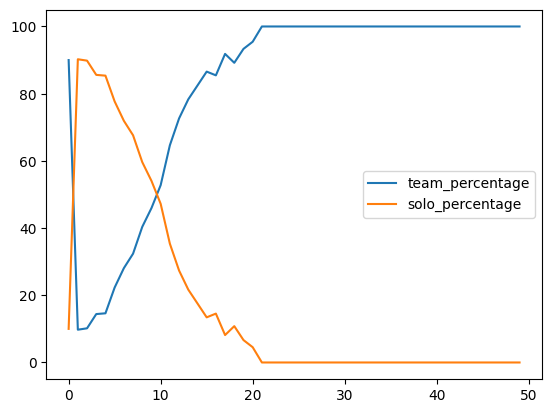

In [93]:
game_stats(game)